In [1]:
'''
created on June 6th 2022 @ 3rd Eddy Cross Disciplinary Symposium, Vail, CO, USA
Code based on original idea by Dan Marsh (NCAR, University of Leeds)
Authors:
Gregory Cooke (University of Leeds, pygjc@leeds.ac.uk)
Allison Youngblood (NASA Goddard)
'''

'''
Code to read in files from the MUSCLES database
and scale them to be used in various atmospheric models
for different planets in those stellar systems
'''

'''
To do list
wget NASA exoplanet archive
rebin spectra
save out spectra file
add different climate model wavelength grids (only WACCM so far)
comment code better
'''

#imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipywidgets import interactive
import matplotlib.gridspec as gridspec
from astropy.io import fits


In [ ]:
# return subscript number or text as a string
def sub(Input):
    return r'$_{'+str(Input)+'}$'

# return superscript number or text as a string
def sup(Input):
    return r'$^{'+str(Input)+'}$'

In [255]:
'''
program options begin here
List of MUSCLES database below
'''

Stellar_names = {'GJ 1132':'https://archive.stsci.edu/missions/hlsp/muscles/gj1132/hlsp_muscles_multi_multi_gj1132_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 15A':'https://archive.stsci.edu/missions/hlsp/muscles/gj15a/hlsp_muscles_multi_multi_gj15a_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 1214':'https://archive.stsci.edu/missions/hlsp/muscles/gj1214/hlsp_muscles_multi_multi_gj1214_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 163':'https://archive.stsci.edu/missions/hlsp/muscles/gj163/hlsp_muscles_multi_multi_gj163_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 176':'https://archive.stsci.edu/missions/hlsp/muscles/gj176/hlsp_muscles_multi_multi_gj176_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 436':'https://archive.stsci.edu/missions/hlsp/muscles/gj436/hlsp_muscles_multi_multi_gj436_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 581':'https://archive.stsci.edu/missions/hlsp/muscles/gj581/hlsp_muscles_multi_multi_gj581_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 649':'https://archive.stsci.edu/missions/hlsp/muscles/gj649/hlsp_muscles_multi_multi_gj649_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 667 C':'https://archive.stsci.edu/missions/hlsp/muscles/gj667c/hlsp_muscles_multi_multi_gj667c_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 674':'https://archive.stsci.edu/missions/hlsp/muscles/gj674/hlsp_muscles_multi_multi_gj674_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 676 A':'https://archive.stsci.edu/missions/hlsp/muscles/gj676a/hlsp_muscles_multi_multi_gj676a_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 699':'https://archive.stsci.edu/missions/hlsp/muscles/gj699/hlsp_muscles_multi_multi_gj699_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 729':'https://archive.stsci.edu/missions/hlsp/muscles/gj729/hlsp_muscles_multi_multi_gj729_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 832':'https://archive.stsci.edu/missions/hlsp/muscles/gj832/hlsp_muscles_multi_multi_gj832_broadband_v22_adapt-const-res-sed.fits',
                 'GJ 849':'https://archive.stsci.edu/missions/hlsp/muscles/gj849/hlsp_muscles_multi_multi_gj849_broadband_v23_adapt-const-res-sed.fits',
                 'GJ 876':'https://archive.stsci.edu/missions/hlsp/muscles/gj876/hlsp_muscles_multi_multi_gj876_broadband_v22_adapt-const-res-sed.fits',
                 'HD40307':'https://archive.stsci.edu/missions/hlsp/muscles/hd40307/hlsp_muscles_multi_multi_hd40307_broadband_v22_adapt-const-res-sed.fits',
                 'HD85512':'https://archive.stsci.edu/missions/hlsp/muscles/hd85512/hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits',
                 'HD97658':'https://archive.stsci.edu/missions/hlsp/muscles/hd97658/hlsp_muscles_multi_multi_hd97658_broadband_v22_adapt-const-res-sed.fits',
                 'L-980-5':'https://archive.stsci.edu/missions/hlsp/muscles/l-980-5/hlsp_muscles_multi_multi_l-980-5_broadband_v23_adapt-const-res-sed.fits',
                 'LHS-2686':'https://archive.stsci.edu/missions/hlsp/muscles/lhs-2686/hlsp_muscles_multi_multi_lhs-2686_broadband_v23_adapt-const-res-sed.fits',
                 'TRAPPIST-1':'https://archive.stsci.edu/missions/hlsp/muscles/trappist-1/hlsp_muscles_multi_multi_trappist-1_broadband_v23_adapt-const-res-sed.fits',
                 'V-EPS-ERI':'https://archive.stsci.edu/missions/hlsp/muscles/v-eps-eri/hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits',
                 'GJ551':'https://archive.stsci.edu/missions/hlsp/muscles/gj551/hlsp_muscles_multi_multi_gj551_broadband_v22_adapt-const-res-sed.fits'}

#get a drop down menu
import ipywidgets as widgets
#select directories for MUSCLES files
MUSCLES_files = widgets.Dropdown(options=(Stellar_names),description='MUSCLES Files:',disabled=False)
display(MUSCLES_files)

Dropdown(description='MUSCLES Files:', options={'GJ 1132': 'https://archive.stsci.edu/missions/hlsp/muscles/gj…

In [ ]:
'''
set Spectra_name_same_as_host_name = False if looking at exoplanets around
a different star to the ones in the MUSCLES database
i.e you want spectra for an M8 star but the closest spectra availiable is TRAPPIST-1
otherwise in this example you will only be able to select TRAPPIST-1 planets 
if Spectra_name_same_as_host_name = True
'''
Spectra_name_same_as_host_name = True

In [256]:
#get star name
star_name = [k for k, v in Stellar_names.items() if v == MUSCLES_files.value][0]

In [257]:
# Import MUSCLES spectra
import os
os.system('wget '+ MUSCLES_files.value)

--2022-06-07 17:11:49--  https://archive.stsci.edu/missions/hlsp/muscles/gj667c/hlsp_muscles_multi_multi_gj667c_broadband_v22_adapt-const-res-sed.fits
Resolving archive.stsci.edu (archive.stsci.edu)... 130.167.201.60
Connecting to archive.stsci.edu (archive.stsci.edu)|130.167.201.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5186880 (4.9M) [allicashion/octet-stream]
Saving to: ‘hlsp_muscles_multi_multi_gj667c_broadband_v22_adapt-const-res-sed.fits.2’

     0K .......... .......... .......... .......... ..........  0%  617K 8s
    50K .......... .......... .......... .......... ..........  1% 1.16M 6s
   100K .......... .......... .......... .......... ..........  2% 1.13M 5s
   150K .......... .......... .......... .......... ..........  3%  144M 4s
   200K .......... .......... .......... .......... ..........  4% 1.24M 4s
   250K .......... .......... .......... .......... ..........  5% 30.5M 3s
   300K .......... .......... .......... .......... .....

0

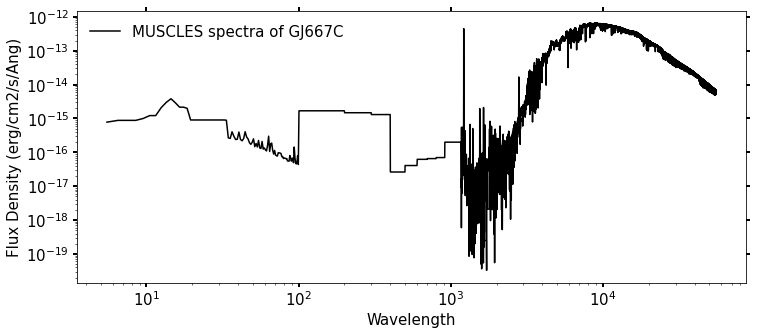

In [200]:
spec = fits.getdata(MUSCLES_files.value,1)
plt.figure(figsize = (12,5))
plt.plot(spec['WAVELENGTH'],spec['FLUX'], color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density (erg/cm2/s/Ang)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [201]:
#convert to mW/m2/nm
per_cm2_to_per_m2 = 100**2
erg_per_s_to_mW = 1e-4
per_Ang_to_per_nm = 10
New_flux = spec['FLUX'] * erg_per_s_to_mW * per_cm2_to_per_m2 * per_Ang_to_per_nm
Wavelength_nm = spec['WAVELENGTH']/10

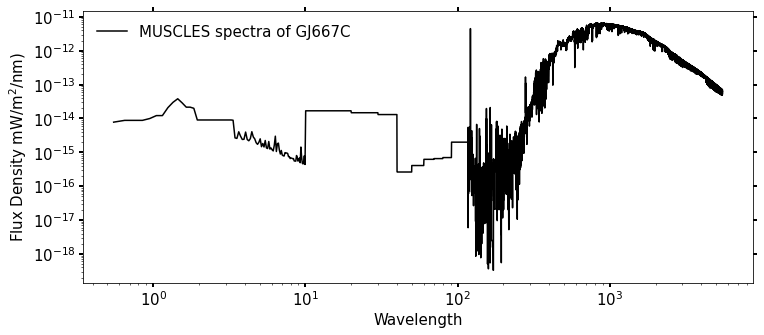

In [202]:
# plot in new units
'''
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm,New_flux, color = 'k', label = 'MUSCLES spectra of '+star_name)
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)
'''

In [285]:
#remove MUSCLES files in current directory
os.system('rm *muscles*.fits')

0

In [286]:
#find total stellar irradiance from file
from scipy.integrate import trapz
#get total stellar irradiance at top of atmosphere
TSI_spectra = trapz(New_flux,Wavelength_nm)
print('Total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Total stellar irradiance relative to the Sun: 5.683981759383584e-15


In [287]:
# scale TSI
Scaled_flux_to_Earth = New_flux/(TSI_spectra/1360000)
TSI_spectra = trapz(Scaled_flux_to_Earth, Wavelength_nm)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Scaled total stellar irradiance relative to the Sun: 0.9999999999999997


--2022-06-07 17:30:04--  https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc
Resolving svn-ccsm-inputdata.cgd.ucar.edu (svn-ccsm-inputdata.cgd.ucar.edu)... 128.117.13.55
Connecting to svn-ccsm-inputdata.cgd.ucar.edu (svn-ccsm-inputdata.cgd.ucar.edu)|128.117.13.55|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 208080 (203K) [application/octet-stream]
Saving to: ‘SolarForcingCMIP6piControl_c160921.nc.1’

     0K .......... .......... .......... .......... .......... 24% 2.18M 0s
    50K .......... .......... .......... .......... .......... 49% 4.16M 0s
   100K .......... .......... .......... .......... .......... 73% 4.26M 0s
   150K .......... .......... .......... .......... .......... 98%  176M 0s
   200K ...                                                   100% 75.3M=0.05s

2022-06-07 17:30:04 (4.32 MB/s) - ‘SolarForcingCMIP6piControl_c160921.nc.1’ 

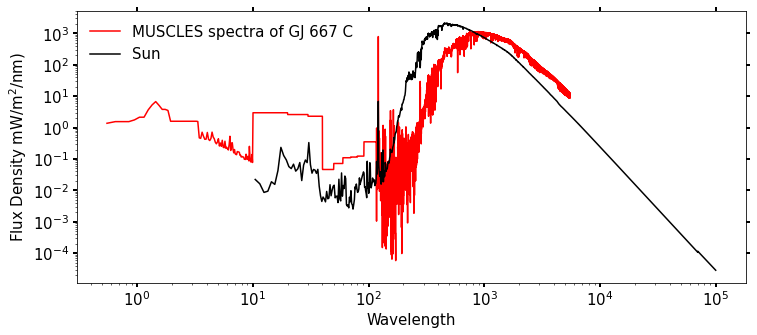

In [288]:
#Compare to WACCM standard solar file
os.system('wget https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/inputdata/atm/cam/solar/SolarForcingCMIP6piControl_c160921.nc --no-check-certificate')
solar_file = 'SolarForcingCMIP6piControl_c160921.nc'#read in file

import xarray as xr
ds = xr.open_dataset(solar_file)#attahc file to dataset

ssi = ds['ssi'].isel(time=0) #define dataset from file

WACCM_Flux = ssi.values
WACCM_wavelength = ssi.wavelength.values

#compare spectra to Sun
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm, Scaled_flux_to_Earth, color = 'r', label = 'MUSCLES spectra of '+star_name)
plt.plot(WACCM_wavelength,WACCM_Flux, color = 'k', label = 'Sun')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)


In [289]:
#Now scale to specific planet in that system
#Use NASA exoplanet archive????

In [290]:
! wget https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload | wget https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

In [291]:
import pandas as pd
NASA_Exo_Archive = pd.read_csv('PS_2022.06.06_22.28.54.csv', skiprows = 290)

/tmp/ipykernel_101/3668818744.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  NASA_Exo_Archive = pd.read_csv('PS_2022.06.06_22.28.54.csv', skiprows = 290)


In [292]:
#Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates() ),description='Find host',disabled=False)
#display(Find_host)

In [293]:
#Find planets based on host name
if (Spectra_name_same_as_host_name == True):
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == star_name]['pl_name']
    Find_planets = widgets.Dropdown(options=planets.drop_duplicates(),description='Find planets',disabled=False)
    display(Find_planets)
else:
    Find_host = widgets.Dropdown(options=(NASA_Exo_Archive['hostname'].drop_duplicates()),description='Find host',disabled=False)
    display(Find_host)
    
    #choose planet
    planets = NASA_Exo_Archive.loc[NASA_Exo_Archive['hostname'] == Find_host.value]['pl_name']
    Find_planets = widgets.Dropdown(options=planets,description='Find planets',disabled=False)
    display(Find_planets)

Dropdown(description='Find planets', options=('GJ 667 C b', 'GJ 667 C c', 'GJ 667 C e', 'GJ 667 C f', 'GJ 667 …

In [294]:
#drop nan rows ofr luminosity and orbital period
pl = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value].dropna(subset='st_lum')
pl = pl.dropna(subset='pl_orbsmax')

In [295]:
#find semi-major axis in AU
pl = pl.sort_values(by=['rowupdate'])
semi_major_axis = pl['pl_orbsmax'].iloc[-1]
print('semi-major axis of '+Find_planets.value+' = '+str(semi_major_axis)+' AU')

semi-major axis of GJ 667 C c = 0.125 AU


In [296]:
#find solar luminosity relative to Sun
stellar_luminosity = 10**pl['st_lum'].iloc[-1]
print('Star has '+str(stellar_luminosity)+ ' times luminosity of Sun')

Star has 0.013708817661648536 times luminosity of Sun


In [297]:
flux_recieved_relative_to_Earth = stellar_luminosity/(semi_major_axis**2)
print(Find_planets.value+' recieves '+str(flux_recieved_relative_to_Earth)+ ' times flux recieved by Earth')

GJ 667 C c recieves 0.8773643303455063 times flux recieved by Earth


In [298]:
#add in infrared wavelengths if required


In [299]:
#rebin to wavelength grid


In [300]:
# rescale to planet
Final_scaled_flux = Scaled_flux_to_Earth * flux_recieved_relative_to_Earth
TSI_spectra = trapz(Final_scaled_flux, Wavelength_nm)
print('Scaled total stellar irradiance relative to the Sun: '+ str(TSI_spectra/1360000))

Scaled total stellar irradiance relative to the Sun: 0.8773643303455062


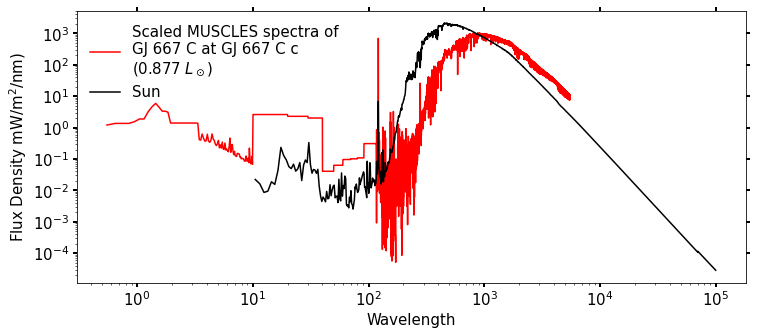

In [308]:
#final spectra compared to Sun
plt.figure(figsize = (12,5))
plt.plot(Wavelength_nm, Final_scaled_flux, color = 'r', label = 'Scaled MUSCLES spectra of\n'+star_name+ ' at ' + Find_planets.value+'\n('+str(round(TSI_spectra/1360000,3))+' '+r'$L_\odot$'+')')
plt.plot(WACCM_wavelength,WACCM_Flux, color = 'k', label = 'Sun')
plt.tick_params(labelsize = 15, width = 2, length = 4, right = True, top = True)
plt.xlabel('Wavelength', fontsize = 15); plt.xscale('log')
plt.ylabel('Flux Density mW/m'+sup(2)+'/nm)', fontsize = 15); plt.yscale('log')
plt.legend(loc = 0, frameon = False, fontsize = 15)

In [49]:
#extra information about planet
period = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value]['pl_orbper']
print(period)

31498    6.101013
31499         NaN
31500    6.099615
Name: pl_orbper, dtype: float64


In [50]:
radius = NASA_Exo_Archive.loc[NASA_Exo_Archive['pl_name'] == Find_planets.value]['pl_rade']
print(radius)

31498    0.920
31499    0.910
31500    0.918
Name: pl_rade, dtype: float64
